For Rapel River samples RP-1, RP-3, RP-4, RP-5, RP-7, RP-8, RP-9, RP-10

In [1]:
import numpy as np
from scipy.interpolate import interp1d

In [2]:
def prod_rate_scaling_factor(lat_geomag):

    lat_target = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
    a = np.array([3.511, 3.360, 4.0607, 4.994, 5.594, 6.064, 5.994, 5.994, 5.994, 5.994])
    b = np.array([2.547, 2.522, 2.734, 3.904, 4.946, 5.715, 6.018, 6.018, 6.018, 6.018])
    c = np.array([0.95125, 1.0668, 1.2673, 0.9739, 1.3817, 1.6473, 1.7045, 1.7045, 1.7045, 1.7045])
    d = np.array([0.18608, 0.18830, 0.22529, 0.42671, 0.53176, 0.68684, 0.71184, 0.71184, 0.71184, 0.71184])

    fun_a = interp1d(lat_target, a, kind = 'cubic')
    fun_b = interp1d(lat_target, b, kind = 'cubic')
    fun_c = interp1d(lat_target, c, kind = 'cubic')
    fun_d = interp1d(lat_target, d, kind = 'cubic')

    def ret_fun(elevation):

        q = fun_a(lat_geomag)+ fun_b(lat_geomag)*elevation + fun_c(lat_geomag)*np.power(elevation,2) + fun_d(lat_geomag)*np.power(elevation,3)
        q_hlle = fun_a(90)

        scaling_factor = q / q_hlle

        return scaling_factor

    return ret_fun

In [3]:
print(prod_rate_scaling_factor(20)(1))

1.3825975975975975


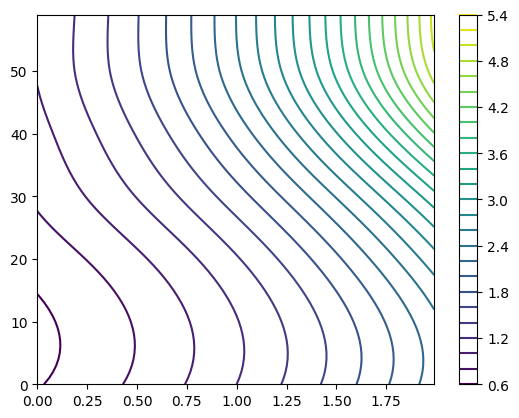

In [4]:
# Recreate Bierman to make sure we did everything right.

import matplotlib.pylab as plt

elev = np.arange(0, 2, 0.01)
lat = np.arange(0,60,1)

scaling = np.zeros((elev.size, lat.size))

for i, e in enumerate(elev):
    for j, l in enumerate(lat):
        scaling[i,j] = prod_rate_scaling_factor(l)(e)

plt.contour(elev, lat,scaling.T, np.arange(0.6, 5.6, 0.2))
plt.colorbar()


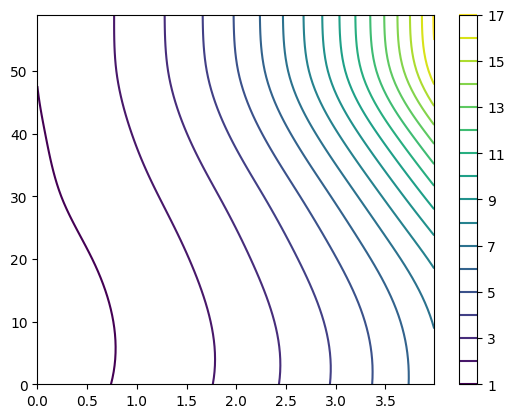

In [5]:
# Recreate Bierman to make sure we did everything right.

import matplotlib.pylab as plt

elev = np.arange(0, 4, 0.01)
lat = np.arange(0,60,1)

scaling = np.zeros((elev.size, lat.size))

for i, e in enumerate(elev):
    for j, l in enumerate(lat):
        scaling[i,j] = prod_rate_scaling_factor(l)(e)

plt.contour(elev, lat,scaling.T, np.arange(1, 18, 1))
plt.colorbar()

In [14]:
import TopoAnalysis.dem as d

elevation = d.Elevation.load('rapel_SRTMGL130m_dem_utm.tif')

In [19]:
import os 
os.chdir("masks")

In [23]:
# samples masks have to be from the dem that they were created from

sample_names = ['RP_1_mask', 'RP_3_mask', 'RP_4_mask', 'RP_5_mask', 'RP_7_mask', 'RP_8_mask', 
                'RP_9_mask', 'RP_10_mask', 'RP_S2_mask', 'RP_S3_mask', 'RP_S3u_mask', 'RP_S4u_mask']
prsf_fun = prod_rate_scaling_factor(34)
values = []
for sample_name in sample_names:
    sample = d.BaseSpatialGrid.load(sample_name)
    i = np.where(sample._griddata == 1)
    #print(sample._griddata.shape, elevation._griddata.shape)
    values += [np.mean(prsf_fun(elevation._griddata[i]/ 1000))]

In [27]:
for name, val in zip(sample_names, values):
    print(name, val)

RP_1_mask 2.7676987221254707
RP_3_mask 3.05629398295525
RP_4_mask 1.0406175319717224
RP_5_mask 3.5405937729641206
RP_7_mask 1.6165443386948035
RP_8_mask 5.153967555598157
RP_9_mask 3.77486248456333
RP_10_mask 6.105431464251634
RP_S2_mask 0.998512187426346
RP_S3_mask 1.0905534270810378
RP_S3u_mask 1.1096714068179931
RP_S4u_mask 1.0855491284850762


In [28]:
# not including 4.1 here yet. need to figure out what to do with 4 and why i split it originally. 

sample_lats = [-33.908524, -34.292129, -34.301552, -34.381495, -34.120319, -34.675155, -34.435514, 
               -34.248991, -33.9458637, -33.96972222, -34.05527778, -34.1531149]
scaling_factors = [2.7676987221254707, 3.05629398295525, 1.0406175319717224, 3.5405937729641206, 
                   1.6165443386948035, 5.153967555598157, 3.77486248456333, 6.105431464251634, 
                   0.998512187426346, 1.0905534270810378, 1.1096714068179931, 1.0855491284850762]

from scipy.optimize import fsolve

for name, lat, sf in zip(sample_names, sample_lats, scaling_factors):

    pr = prod_rate_scaling_factor(-lat)

    def misfit(elev):
        dif =  pr(elev) - sf
        return dif

    effective_elev = fsolve(misfit, 1)

    print(name, effective_elev*1000)

RP_1_mask [1572.62336386]
RP_3_mask [1707.12853111]
RP_4_mask [206.31409738]
RP_5_mask [1925.8791912]
RP_7_mask [797.97814996]
RP_8_mask [2505.21039238]
RP_9_mask [2022.09878702]
RP_10_mask [2802.85930826]
RP_S2_mask [159.81664259]
RP_S3_mask [272.25416053]
RP_S3u_mask [293.23000894]
RP_S4u_mask [263.01979165]


In [29]:
# P = NE / capital lambda
atten = 160 # /cm^2 attenuation length
p = 2.6 # g/cm^3 density

# RP-1, RP-S2, RP-S3, RP-S3u, RP-S4u

N = np.array([1.12E+05, 3.79E+04, 9.79E+04, 1.12E+05, 4.72E+04]) # nuclide concetration in atm/g
Nu = np.array([2.08E+03, 7.77E+02, 1.83E+03, 2.11E+03, 1.84E+03]) # nuclide concentration uncertainty
E = np.array([72.2, 84.9, 34, 30, 72.8]) # erosion rate in m/myr
Eu = np.array([]) # erosion rate uncertainty from using no uncertainty in CRONUS (m/myr)

Ecm = (E * 100) / 1000000 # erosion rate in cm/yr

print("Production Rates (atm/g/yr):")

P = N * Ecm * p / atten
print(P)

Production Rates (atm/g/yr):
[13.1404      5.22877875  5.408975    5.46        5.58376   ]
